In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [31]:
source('main.R')

data <- kaggle.house$loadData()
df.training <- data$train
df.testing <- data$test
df.combined <- kaggle.house$getCombinedDataset(df.training, df.testing)

stopifnot(nrow(df.training) + nrow(df.testing) == nrow(df.combined))
stopifnot(setdiff(df.training %>% colnames, df.testing %>% colnames) == c('SalePrice'))

In [71]:
# Attributes where NAs means that something is not present
columns.with.good.na <- kaggle.house$na$colums.with.good.na

# Attributes where NAs do not carry information and are pure data misses
columns.with.bad.na <- df.combined %>% 
select(-dplyr::one_of(colums.with.good.na), 
       -dplyr::one_of(kaggle.house$na$columns.with.technical.na)) %>% 
purrr::keep(function (col) { sum(is.na(col)) > 0 }) %>% names

df.combined.na.good <- df.combined %>% select(dplyr::one_of(colums.with.good.na))
df.combined.na.bad <- df.combined %>% select(dplyr::one_of(columns.with.bad.na))

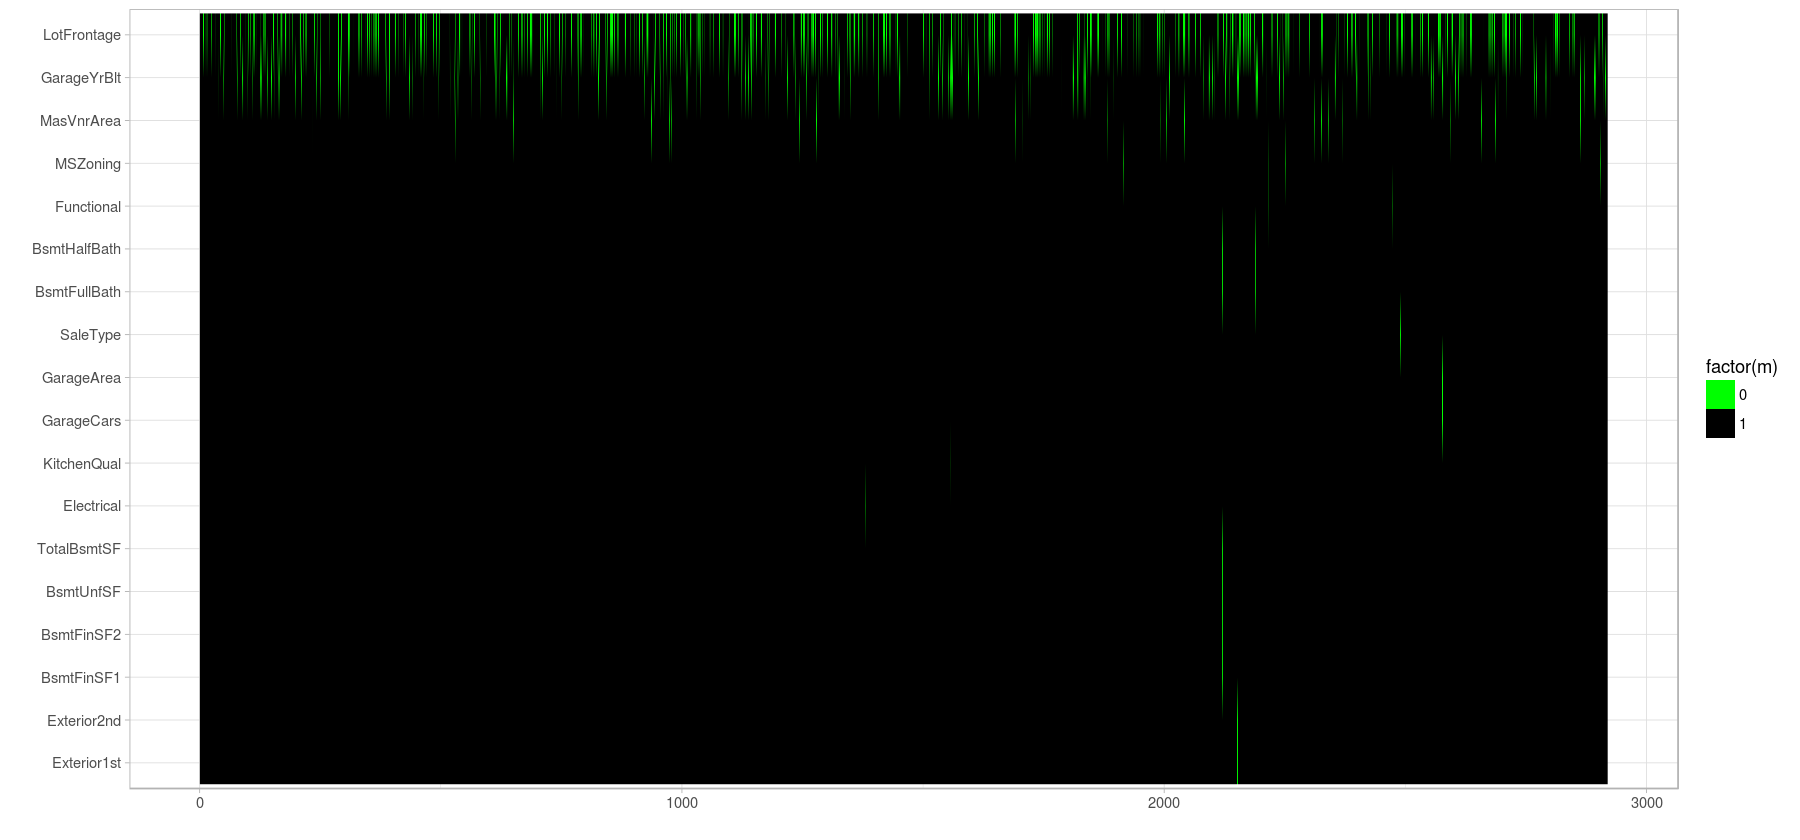

In [72]:
# Plot bad NAs
options(repr.plot.width = 15, repr.plot.height = 7)

# Order attributes by NAs amount
cols.order <- df.combined.na.bad %>% is.na %>% colSums %>% sort %>% names

df.combined.na.bad %>%
mutate(x = row_number()) %>%
gather(col.name, col.value, -x) %>% 
mutate(m = ifelse(is.na(col.value), 0, 1)) %>% 
select(-col.value) %>%
mutate(col.name = factor(col.name, levels=cols.order)) %>%
ggplot() + geom_raster(aes(x=x, y=col.name, fill=factor(m)), interpolate=TRUE) + 
scale_fill_manual(values=c("green", "black")) + theme_light() + ylab("") + xlab("") 

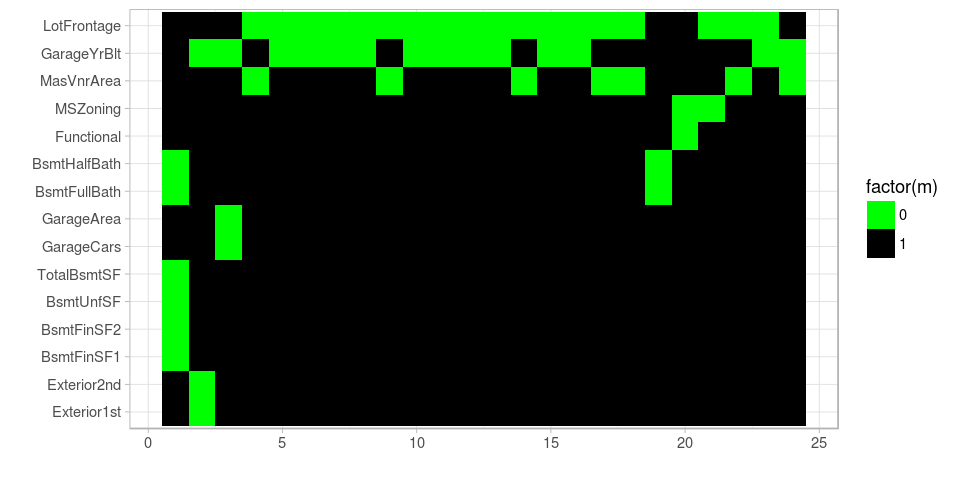

In [73]:
options(repr.plot.width = 8, repr.plot.height = 4)

df.combined.na.bad %>% 
mutate(na.row.count = apply(., 1, function(r) { sum(is.na(r)) })) %>% 
filter(na.row.count > 1) %>%
arrange(desc(na.row.count)) %>%
purrr::keep(function (col) { sum(is.na(col)) > 0 }) %>%
mutate(x = row_number()) %>%
gather(col.name, col.value, -x) %>% 
mutate(m = ifelse(is.na(col.value), 0, 1)) %>% 
select(-col.value) %>%
mutate(col.name = factor(col.name, levels=cols.order)) %>%
ggplot() + geom_tile(aes(x=x, y=col.name, fill=factor(m))) + 
scale_fill_manual(values=c("green", "black")) + theme_light() + ylab("") + xlab("") 

In [74]:
# Character attributes with bad NAs
df.combined.na.bad %>% select_if(is.character) %>% 
purrr::keep(function (col) { sum(is.na(col)) > 0 }) %>%
purrr::map(function (col) { table(col, useNA='always') %>% as.data.frame }) %>%
purrr::map(function (df) { df %>% spread(col, Freq) }) -> tmp

tmp[tmp %>% names %>% sort]

$Electrical
  FuseA FuseF FuseP Mix SBrkr <NA>
1   188    50     8   1  2671    1

$Exterior1st
  AsbShng AsphShn BrkComm BrkFace CBlock CemntBd HdBoard ImStucc MetalSd
1      44       2       6      87      2     126     442       1     450
  Plywood Stone Stucco VinylSd Wd Sdng WdShing <NA>
1     221     2     43    1025     411      56    1

$Exterior2nd
  AsbShng AsphShn Brk Cmn BrkFace CBlock CmentBd HdBoard ImStucc MetalSd Other
1      38       4      22      47      3     126     406      15     447     1
  Plywood Stone Stucco VinylSd Wd Sdng Wd Shng <NA>
1     270     6     47    1014     391      81    1

$Functional
  Maj1 Maj2 Min1 Min2 Mod Sev  Typ <NA>
1   19    9   65   70  35   2 2717    2

$KitchenQual
   Ex Fa   Gd   TA <NA>
1 205 70 1151 1492    1

$MSZoning
  C (all)  FV RH   RL  RM <NA>
1      25 139 26 2265 460    4

$SaleType
  COD Con ConLD ConLI ConLw CWD New Oth   WD <NA>
1  87   5    26     9     8  12 239   7 2525    1

In [75]:
# Numeric attributes with bad NAs
df.combined.na.bad %>% 
select_if(is.numeric) %>%
gather(col.name, col.value) %>%
mutate(m = is.na(col.value)) %>%
group_by(col.name, m) %>%
count %>% filter(m == TRUE) %>% ungroup %>% select(-m) %>% spread(col.name, n)

BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,GarageArea,GarageCars,GarageYrBlt,LotFrontage,MasVnrArea,TotalBsmtSF
1,1,2,2,1,1,1,159,486,23,1


In [76]:
# Fix good NAs
df.combined.good.na.fixed <- 
    kaggle.house$na$fixGoodNa(df.combined) %>%
    select(dplyr::one_of(colums.with.good.na))

# All NAs should be gone
stopifnot(is.na(df.combined.good.na.fixed) %>% sum == 0)

# Character NAs should be replaced with '_none_' value
fn <- function(before, after) { 
    !( is.na(before) & after == '_none_' | !is.na(before) & (before == after) ) 
}
stopifnot(purrr::map2_dfc(df.combined.na.good %>% select_if(is.character), 
                          df.combined.good.na.fixed %>% select_if(is.character), fn) %>% as.matrix %>% sum == 0)

# Numeric NAs should be replaced with zero value
fn <- function(before, after) { 
    !( is.na(before) & after == 0 | !is.na(before) & (before == after) ) 
}
stopifnot(purrr::map2_dfc(df.combined.na.good %>% select_if(is.numeric), 
                          df.combined.good.na.fixed %>% select_if(is.numeric), fn) %>% as.matrix %>% sum == 0)

In [81]:
# Fix bad NAs
df.combined.bad.na.fixed <- 
    kaggle.house$na$fixBadNa(df.combined) %>%
    select(dplyr::one_of(columns.with.bad.na))

# All NAs should be gone
stopifnot(sum(is.na(df.combined.bad.na.fixed)) == 0)

# If it was NA before, it should not be after.
# If it was not NA before, it should be exacltly same value
fn <- function(before, after) { 
    !( is.na(before) & !is.na(after) | !is.na(before) & (before == after) ) 
}
stopifnot(purrr::map2_dfc(df.combined.na.bad, df.combined.bad.na.fixed, fn) %>% as.matrix %>% sum == 0)

In [80]:
# Fix it all except technical NAs

df.combined.before <- 
    df.combined %>% select(-dplyr::one_of(kaggle.house$na$columns.with.technical.na))

df.combined.after <- 
    df.combined %>% select(-dplyr::one_of(kaggle.house$na$columns.with.technical.na)) %>%
    (kaggle.house$na$fixAll)

# All NAs should be gone
stopifnot(is.na(df.combined.after) %>% sum == 0)

# Character good NAs should be replaced with '_none_' value
fn <- function(before, after) { 
    !( is.na(before) & after == '_none_' | !is.na(before) & (before == after) ) 
}
stopifnot(purrr::map2_dfc(df.combined.before %>% 
                              select(dplyr::one_of(colums.with.good.na)) %>% 
                              select_if(is.character),
                          df.combined.after %>% 
                              select(dplyr::one_of(colums.with.good.na)) %>% 
                              select_if(is.character), fn) %>% as.matrix %>% sum == 0)

#Numeric good NAs should be replaced with zero value
fn <- function(before, after) { 
    !( is.na(before) & after == 0 | !is.na(before) & (before == after) ) 
}
stopifnot(purrr::map2_dfc(df.combined.before %>% 
                              select(dplyr::one_of(columns.with.good.na)) %>% 
                              select_if(is.numeric),
                          df.combined.after %>% 
                              select(dplyr::one_of(columns.with.good.na)) %>% 
                              select_if(is.numeric), fn) %>% as.matrix %>% sum == 0)

# Checking bad NAs
fn <- function(before, after) { 
    !( is.na(before) & !is.na(after) | !is.na(before) & (before == after) ) 
}
stopifnot(purrr::map2_dfc(df.combined.before %>% 
                              select(dplyr::one_of(columns.with.bad.na)), 
                          df.combined.after %>% 
                              select(dplyr::one_of(columns.with.bad.na)), fn) %>% as.matrix %>% sum == 0)